In [1]:
from scipy.stats import norm
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def epanechnikov_kernel(z):
    
    '''
    INPUT
    ----------
    z : array-like
        Kernel input. Usually a result of (x - x_0) / h
        
    OUTPUT
    ----------
    epanechnikov_kernel : array-like
                          Result of epanechnikov kernel
    '''
    
    return (3 / 4) * (1 - z ** 2) * (np.abs(z) < 1)

def gaussian_kernel(z):
    
    
    '''
    INPUT
    ----------
    z : array-like
        Kernel input. Usually a result of (x - x_0) / h
        
    OUTPUT
    ----------
    gaussian_kernel : array-like
                      Result of gaussian kernel
    '''
    
    return (2 * math.pi) ** (-1 / 2) * np.exp(z ** 2 / 2)

def triweight_kernel(z):
    
    '''
    INPUT
    ----------
    z : array-like
        Kernel input. Usually a result of (x - x_0) / h
        
    OUTPUT
    ----------
    triweight_kernel : array-like
                       Result of triweight kernel
    '''
    
    return (35 / 32) * (1 - z ** 2) ** 3 * (np.abs(z) < 1)

def plug_in_h(X, delta):
    
    '''
    INPUT
    ----------
    X : array-like
        An array, based on which the optimal bandwidth is calculated via the plug-in method.
    delta : float
            A number, which corresponds to each kernel's optimal bandwidth selection
            
    OUTPUT
    ----------
    h : float
        Optimal bandwidth.
    '''
    
    N = X.shape[0]
    stdev = np.std(X)
    
    return 1.3643 * delta * (N ** (-1 / 5)) * stdev

def silverman_h(X, delta):
    
    '''
    INPUT
    ----------
    X : array-like
        An array, based on which the optimal bandwidth is calculated via the silverman method.
    delta : float
            A number, which corresponds to each kernel's optimal bandwidth selection
            
    OUTPUT
    ----------
    h : float
        Optimal bandwidth.
    '''
    
    N = X.shape[0]
    stdev = np.std(X)
    iqr = np.percentile(X, 75, interpolation='midpoint') - np.percentile(X, 25, interpolation='midpoint')
    
    return 1.3643 * delta * (N ** (-1 / 5)) * np.min([stdev, iqr / 1.349])

def cross_validation_h(Y, X, kernel):
    
    '''
    INPUT
    ----------
    Y : array-like
        An array containing the target variable.
        
    X : array-like
        An array containing the predictors.
        
    kernel : string
             A string indicating the choice of kernel used in the estimation. Possible values are: 
             gaussian, triweight and epanechnikov.
             
    OUTPUT
    ----------
    optimal_h : float
                An optimal bandwidth.
    '''
    
    N = X.shape[0]
    bandwidth_values = np.arange(0.2, 1, 0.05)
    
    optimal_h = 10000
    CV = 10000
    
    if kernel == 'epanechnikov':
        k = epanechnikov_kernel
    elif kernel == 'gaussian':
        k = gaussian_kernel
    else:
        k = triweight_kernel
        
    iota = np.ones(N)
    differ = np.zeros(N)
    for bandwidth in bandwidth_values:
        for i in range(N):
            weights = np.zeros(N)

            X_0 = X[i]
            Z = (iota * X_0 - X) / bandwidth
            KX = k(Z)

            YKX = Y * KX
            m_regress = np.mean(YKX) / np.mean(KX)

            for j in range(N):
                Z_nom = (X_0 - X[j]) / bandwidth
                nominator = (1 / (N * bandwidth)) * k(Z_nom)

                Z_denom = (iota * X_0 - X) / bandwidth
                denominator = (1 / (N * bandwidth)) * np.sum(k(Z_denom))

                weights[j] = nominator / denominator

            differ[i] = (Y[i] - m_regress) / (1 - (weights[i] / np.sum(weights)))

        lower_X = np.percentile(X, 5, interpolation='midpoint')
        upper_X = np.percentile(X, 95, interpolation='midpoint')

        pi = np.zeros(N)
        for i in range(N):
            pi[i] = int(((X[i] < upper_X) & (X[i] > lower_X)))

        CV_val = np.sum(differ ** 2 * pi)
        
        if CV_val < CV:
            CV = CV_val
            optimal_h = bandwidth
        
        
        
    return optimal_h         

In [3]:
def npregress(Y, X, kernel, bandwidth, bandwidth_optimal=None, Xmidpoints=None, nrbins=100, scale=1):
    
    '''
    INPUT
    ----------
    Y : array-like
        An array containing target variables.
    
    X : array-like
        An array containing the explanatory variables.
        
    kernel : string
             A string indicating the kernel choice used in the regression estimation.
             
    bandwidth : float
                A value from an open interval of (0, 1) indicating the width of a bin.
    
    bandwidth_optimal : string
                        A string indicating, whether a method of some sort should be use
                        to determine the optimal bandwidth. Possible values:
                        
                            None : a width from function's argument will be used
                            plug_in : a plug-in method will be used to determine 
                                      optimal bandwidth
                            silverman : silverman's estimate of optimal bandwidth
                            cross_validation : cross validation minimizing

    Xmidpoint : array-like
                An array-like object determining the midpoints to be used. If none are
                provided, the midpoints will be generated from the data.
    
    nrbins : integer
             A number of bins, which will be used in the estimation
    
    scale : float
            A number from (0, 1] indicating the scale, by which the bandwidth will be 
            normalized. This scale is especially useful for plug-in and silverman 
            estimates as these tend to overestimate the optimal bandwidht, producing a 
            flatter than desired regression function.
            
    OUTPUT
    ----------
    Xmidpoints_used : array-like
                      An array containing the midpoints used in the regression fitting.
                      
    m_regress : array-like
                An array containing the fitted values. Result of corresponding kernel and
                bandwidth.
    
    bandwidth_used : float
                     A bandwidth, which was used during the estimation. If no bandwidth 
                     optimization is used, this number corresponds to the value of 
                     bandwidth parameter.
    '''
    
    nrows, ncols = X.shape
    
    YX = np.concatenate((Y, X), axis=1)
    YX = YX[YX[:,1].argsort()]
    
    Y = YX[:, 0]
    X = YX[:, 1]
    
    meanX = np.mean(X)
    stdX = np.std(X)
    iota = np.ones([nrows, 1])
    
    if Xmidpoints == None:
        nrbins = nrbins
        
        lowerX = X[int(np.floor(0.01 * nrows))]
        upperX = X[int(np.floor(0.99 * nrows - 1))]
        
        Xmidpoints_used = np.reshape(np.linspace(lowerX, upperX, nrbins), newshape=(nrbins, 1))
        
    else:
        nrbins, ncbins = Xmidpoints.size
        Xmidpoints_used = Xmidpoints
        
    firstb = Xmidpoints_used[0, :]
    lastb = Xmidpoints_used[nrbins - 1, :]
    binsize = ((lastb - firstb) / nrbins)
    
    if kernel == 'epanechnikov':
        k = epanechnikov_kernel
        delta = 1.7188
    elif kernel == 'gaussian':
        k = gaussian_kernel
        delta = 0.7764
    else:
        k = triweight_kernel
        delta = 2.3122
    
    if bandwidth_optimal == None:
        bandwidth_used = bandwidth
    elif bandwidth_optimal == 'plug_in':
        bandwidth_used = plug_in_h(X, delta)
    elif bandwidth_optimal == 'silverman':
        bandwidth_used = silverman_h(X, delta)
    else:
        bandwidth_used = cross_validation_h(Y, X, kernel)
        
    m_regress = np.zeros(nrbins)
    
    bandwidth_used = bandwidth_used * scale
    
    for j in range(nrbins):
        Xb = Xmidpoints_used[j, 0]
        Z = (iota * Xb - X) / bandwidth_used
        KX = k(Z)
        
        YKX = Y * KX
        m_regress[j] = np.mean(YKX) / np.mean(KX)

        
    return Xmidpoints_used, m_regress, bandwidth_used

In [4]:
def normpdf(x):
    pi = 3.1415926
    denom = (2*pi*np.var(x))**.5
    num = np.exp(-(x-np.mean(x))**2/(2*np.var(x)))
    return num/denom

def generate_data(N):
    
    X = np.random.uniform(low=0, high=30, size=(N, 1))
    u = np.random.normal(loc=0, scale=1, size=(N, 1))
    X = np.sort(X)
    y = (np.sin(X) + 2) * X + u
    
    yX = np.concatenate((y, X), axis=1) 
    
    yX = yX[yX[:, 1].argsort()]
    
    return yX 

## Data generation

In [5]:
data = generate_data(1000)

#### OLS

In [6]:
def local_weighted_OLS(dataset, index):
    
    '''
    INPUT
    ----------
    dataset : array-like
              An array containing the dataset, on which the LWOLS is calculated.
              
    index : integer
            A number indicating the observation, for which the LWOLS is calculated.
            
    OUTPUT
    ----------
    OLS_est : float
              A fitted value as a result of LWOLS method.
    '''
    
    y = dataset[:, 0]
    X = dataset[:, 1]
    
    N = X.shape[0]
    
    x_0 = X[index]
    
    var_X = np.sum((X - np.mean(X)) ** 2)
    peacewise_var_X = X - np.mean(X)
    
    OLS_est = np.sum(((1 / N) + (x_0 - np.mean(X)) * peacewise_var_X / var_X) * y)
    
    return OLS_est

In [7]:
OLS_est = np.zeros([data.shape[0], 2])

for i in range(data.shape[0]):
    
    OLS_est[i, 0] = local_weighted_OLS(data, i)
    OLS_est[i, 1] = data[i, 1]

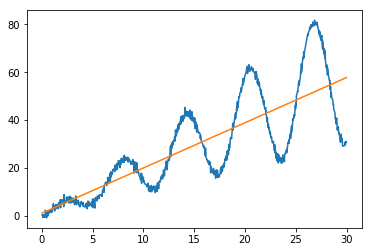

In [8]:
plt.plot(data[:, 1], data[:, 0])
plt.plot(OLS_est[:, 1], OLS_est[:, 0])
plt.show()

#### $k$ nearest neighbors

In [9]:
#function generating data
def generate_data_sinx_x(N):
    
    X = np.random.uniform(low=0, high=30, size=(N, 1))
    u = np.random.normal(loc=0, scale=10, size=(N, 1))
    y = (np.sin(X) + 2) * X + u
    
    yX = np.concatenate((y, X), axis=1) 
    
    yX = yX[yX[:, 1].argsort()]
    
    return yX

#function generating data
def generate_data_expx_x(N):
    
    X = np.random.uniform(low=0, high=4, size=(N, 1))
    u = np.random.normal(loc=0, scale=25, size=(N, 1))
    y = (np.exp(X) + 2) * X + u
    
    yX = np.concatenate((y, X), axis=1) 
    
    yX = yX[yX[:, 1].argsort()]
    
    return yX

#function generating data
def generate_data_absx_x(N):
    
    X = np.random.uniform(low=0, high=50, size=(N, 1))
    u = np.random.normal(loc=0, scale=50, size=(N, 1))
    y = (-np.abs(X-25) + 25) * X + u
    
    yX = np.concatenate((y, X), axis=1) 
    
    yX = yX[yX[:, 1].argsort()]
    
    return yX


#calculating the knn_mean_value for one observation
def knn_mean (response, no, step):
    if no - step >= 0 & no + step <= response.shape[0]:
        knn_mean_i = np.mean(response[(no - step) : (no + step + 1)])
        return(knn_mean_i)
    else:
        return(knn_mean(response, no, step-1))
            
#iterates knn_mean over the dataset
def knn_regr (dataset, k):
    #print('Be sure that Y is the first column and X is the second column!')
    N = dataset.shape[0]
    target = np.zeros(N)
    data = dataset[dataset[:, 1].argsort()]
    Y = dataset[:, 0]
    X = dataset[:, 1]
                    
    for i in range(N):
        target[i] = knn_mean(Y, i, k)
        
    return(target)

#squared error
def MSE (target, predicted):
    return(np.sum((target-predicted) ** 2))

#measure of smoothnes
def discr_smoothness(series):
    sum_of_jumps = 0
    for i in range(1,series.shape[0]-1):
        sum_of_jumps += np.abs((series[i+1] - 2 * series[i] + series[i-1])/2)
        
    return(sum_of_jumps)    

#returns squared error, measure of smoothnes, penalized MSE and list of pred. values
def knn_regr_komplit (dataset, init_k, lam):
    data = dataset[dataset[:, 1].argsort()]
    predicted = knn_regr(data, init_k)
    ms_error = MSE(predicted, data[:, 0])    
    jumps = discr_smoothness(predicted)
    penal = np.abs(ms_error + lam * jumps)
           
    return(ms_error, discr_smoothness(predicted), penal, predicted)

#finds the optimal k for set lambda
def optimal_k (dataset, init_k, lam):
    data = dataset[dataset[:, 1].argsort()]
    a, b, c, d = knn_regr_komplit(data, init_k, lam)
    predicted_init = d
    ms_error_init = a  
    jumps_init = b
    penal_best = c
    best_k = init_k       
    
    for k in np.arange(6, 273, 3):
        penal_new = knn_regr_komplit(data, k, lam)[2]
        if penal_new < penal_best:
            best_k = k
        
    return(best_k)

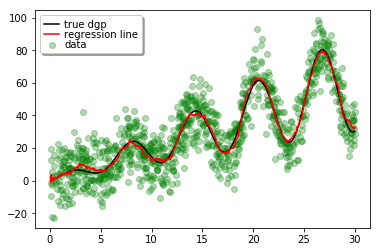

MSE: 100673.240797
Jumps: 213.006279325
Penal: 109193.49197
For lambda = 40  the optimal k is: 20


In [10]:
#generate data and set lambda
data = generate_data_sinx_x(1000)
lam = 40
#find optimal k
opt_k = optimal_k(data, 20, lam)
#run knn regression with optimal k, plot results
a, b, c, d = knn_regr_komplit(data, opt_k, lam)
plt.scatter(data[:, 1], data[:, 0], alpha = 0.3, c = 'green', label = 'green')
plt.plot(data[:, 1], (np.sin(data[:, 1]) + 2) * data[:, 1], c = 'black')
plt.plot(data[:, 1], d, c = 'red')
plt.legend(['true dgp', 'regression line', 'data'], ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
#plt.savefig('sinx_x.png', dpi = 500)
plt.show()

print('MSE:', a)
print('Jumps:', b)
print('Penal:', c)
print('For lambda =', lam, ' the optimal k is:', opt_k)

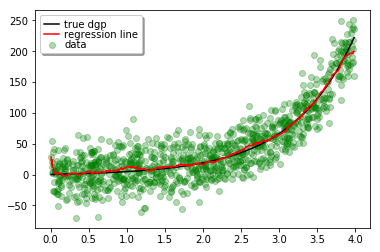

MSE: 623446.183923
Jumps: 298.018534461
Penal: 635366.925302
For lambda = 40  the optimal k is: 36


In [11]:
#generate data and set lambda
data = generate_data_expx_x(1000)
lam = 40
#find optimal k
opt_k = optimal_k(data, 20, lam)
#run knn regression with optimal k, plot results
a, b, c, d = knn_regr_komplit(data, opt_k, lam)
plt.scatter(data[:, 1], data[:, 0], alpha = 0.3, c = 'green', label = 'green')
plt.plot(data[:, 1], (np.exp(data[:, 1]) + 2) * data[:, 1], c = 'black')
plt.plot(data[:, 1], d, c = 'red')
plt.legend(['true dgp', 'regression line', 'data'], ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
#plt.savefig('expx_x.png', dpi = 500)
plt.show()

print('MSE:', a)
print('Jumps:', b)
print('Penal:', c)
print('For lambda =', lam, ' the optimal k is:', opt_k)

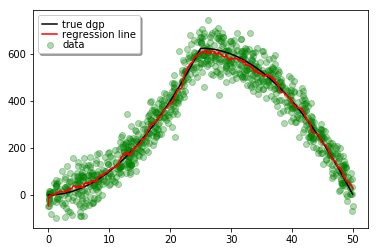

MSE: 2525648.35633
Jumps: 1127.21649134
Penal: 2570737.01599
For lambda = 40  the optimal k is: 18


In [12]:
#generate data and set lambda
data = generate_data_absx_x(1000)
lam = 40
#find optimal k
opt_k = optimal_k(data, 20, lam)
#run knn regression with optimal k, plot results
a, b, c, d = knn_regr_komplit(data, opt_k, lam)
plt.scatter(data[:, 1], data[:, 0], alpha = 0.3, c = 'green', label = 'green')
plt.plot(data[:, 1], (-np.abs(data[:, 1]-25) + 25) * data[:, 1], c = 'black')
plt.plot(data[:, 1], d, c = 'red')
plt.legend(['true dgp', 'regression line', 'data'], ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
plt.savefig('absx_x.png', dpi = 500)
plt.show()


print('MSE:', a)
print('Jumps:', b)
print('Penal:', c)
print('For lambda =', lam, ' the optimal k is:', opt_k)

#### Regression with silverman/plug-in bandwidth optimization

In [13]:
lam = 40

In [14]:
%%time
N = 1000
data = generate_data(N)
y = np.reshape(data[:, 0], (data[:, 0].shape[0], 1))
X = np.reshape(data[:, 1], (data[:, 1].shape[0], 1))

y_target = np.zeros(100)
j = 0
for i in range(0, 1000, 10):
    y_target[j] = y[i]
    j = j + 1

penal = 100000
optimal_scale = 1

for s in np.arange(0.05, 1.05, 0.05):
    
    midpoints, fitted, band = npregress(Y=y, X=X, kernel='epanechnikov', 
                                        bandwidth=0.2, bandwidth_optimal='plug_in',
                                        nrbins=100, scale=s)
    penal_s = np.abs(MSE(y_target, fitted) + lam * discr_smoothness(fitted))
    
    if penal_s < penal:
        penal = penal_s
        optimal_scale = s
        
print('Optimal scale is: ', optimal_scale)
print('The penalized MSE value is: ', penal)

Optimal scale is:  0.35
The penalized MSE value is:  5518.87558791
Wall time: 1min 40s


In [15]:
midpoints, fitted, band = npregress(Y=y, X=X, kernel='epanechnikov', 
                                        bandwidth=0.2, bandwidth_optimal='plug_in',
                                        nrbins=100, scale=optimal_scale)

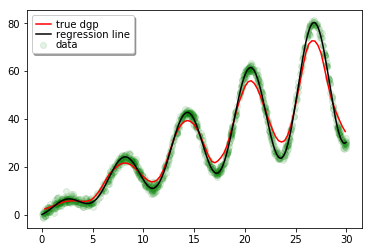

In [16]:
data = generate_data(1000)
plt.scatter(X, y, alpha=0.1, c = 'green', label = 'green')
plt.plot(midpoints, fitted, c='red', label = 'red')
#nasolil jsem sem ten sinus, ale nevim, jestli to nemas upraveny
plt.plot(data[:, 1], (np.sin(data[:, 1]) + 2) * data[:, 1], c = 'black', label = 'black')
#u ty legendy pls ocekuj poradi, ale takhle by to melo byt ok
plt.legend(['true dgp', 'regression line', 'data'], ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
#obvi
plt.savefig('Epanechnikov_plug_in_scale10_sinX.png', dpi = 500)
plt.show()

#### Regression with cross-validation

In [17]:
%%time
N = 1000
data = generate_data(N)
y = np.reshape(data[:, 0], (data[:, 0].shape[0], 1))
X = np.reshape(data[:, 1], (data[:, 1].shape[0], 1))



y_target = np.zeros(100)
j = 0
for i in range(0, 1000, 10):
    y_target[j] = y[i]
    j = j + 1

midpoints, fitted, band = npregress(Y=y, X=X, kernel='epanechnikov', 
                                    bandwidth=0.2, bandwidth_optimal='cross_validation',
                                    nrbins=100, scale=0.1)

C:\Users\Radim\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 11min 12s


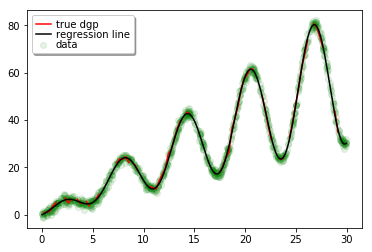

In [18]:
plt.scatter(X, y, alpha=0.1, c = 'green', label = 'green')
plt.plot(midpoints, fitted, c='red', label = 'red')
#nasolil jsem sem ten sinus, ale nevim, jestli to nemas upraveny
plt.plot(data[:, 1], (np.sin(data[:, 1]) + 2) * data[:, 1], c = 'black', label = 'black')
#u ty legendy pls ocekuj poradi, ale takhle by to melo byt ok
plt.legend(['true dgp', 'regression line', 'data'], ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
#obvi
plt.savefig('Epanechnikov_crossvalidation_scale10.png', dpi = 500)
plt.show()